# Оптимизация управления песоналом компании "Работа с заботой".

**Задачи проекта:**

- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**План проекта:**
1. Предсказание уровня удовлетворённости сотрудника:
    - Изучение данных;
    - Предобработка данных;
    - Исследовательский анализ;
    - Подготовка данных;
    - Обучение моделей.
2. Предсказание увольнения сотрудника из компании:
    - Изучение данных;
    - Предобработка данных;
    - Исследовательский анализ;
    - Добавление нового входного признака;
    - Подготовка данных;
    - Обучение моделей.

**Описание данных:**

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install phik -q
!pip install -U scikit-learn -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import phik

import time



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   PolynomialFeatures,
                                   RobustScaler)

from sklearn.metrics import (roc_auc_score,
                            make_scorer)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import  RandomizedSearchCV

RANDOM_STATE = 42

In [3]:
def box_hist_plot(data, feature, title, bins):
    """
    Строит распределение и диаграмму размаха для количественных признаков
    """
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    # Строим боксплот вверху
    sns.boxplot(x=data[feature], ax=ax_box)
    # Строим гистограмму внизу
    ax_hist.hist(data[feature], bins=bins)
    ax_box.set_title(title)
    plt.ylabel('Количество')
    # Убираем подпись оси X для боксплота
    ax_box.set(xlabel='')
    plt.tight_layout()
    plt.grid()
    plt.show()

In [4]:
def box_count_plot(data, feature, title, xlabel):
    """
    Строит диаграмму количества наблюдений
    """
    plt.subplots(figsize = (10,5))
    sns.countplot(x = data[feature], data =  data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.grid()
    plt.show()

In [5]:
def pie_plotter(data, feature, title):
    """
    Строит круговую диаграмму распределения для категориальных данных
    """
    fig = plt.figure(figsize=(6, 4))
    values = data[feature].value_counts(normalize=True)
    plt.pie(
    values,
    labels = values.index,
    autopct='%1.1f%%',
    )
    plt.title(title)
    
    plt.show()

In [6]:
try:
    job_X_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal='.', sep=',')
    job_X_test = pd.read_csv('/datasets/test_features.csv', decimal='.', sep=',')
    job_y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal='.', sep=',')
    quit_X_train = pd.read_csv('/datasets/train_quit.csv')
    quit_y_test = pd.read_csv('/datasets/test_target_quit.csv')
except:
    job_X_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', decimal='.', sep=',')
    job_X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', decimal='.', sep=',')
    job_y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', decimal='.', sep=',')
    quit_X_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    quit_y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')    


## Предсказание уровня удовлетворённости сотрудника

### Изучение данных

#### Тренировочная выборка

In [7]:
#выводим первые пять строк
job_X_train.head() 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [8]:
#выведем информацию о датасете
job_X_train.info()
#посмотрим пропуски в данных
job_X_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

#### Входные признаки тестовой выборки

In [9]:
#выводим первые пять строк
job_X_test.head() 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
#выведем информацию о датасете
job_X_test.info()
#посмотрим пропуски в данных
job_X_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

#### Целевой признак тестовой выборки

In [11]:
#выводим первые пять строк
job_y_test.head() 

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [12]:
# Выведем информацию о датасете
job_y_test.info()
# Посмотрим пропуски в данных
job_y_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


id                       0
job_satisfaction_rate    0
dtype: int64

**Вывод:**

- Датасет `job_X_train`: в данных имеется 4000 записей, в двух столбцах имеются пропуски;
- Датасет `job_X_test`: в данных имеется 2000 записей, в двух столбцах имеются пропуски;
- Датасет `job_y_test`: в данных имеется 2000 записей, пропуски отсутствуют;

Все типы данных в датасетах верные, изменят не нужно.

### Предобработка данных

#### job_X_train

In [13]:
job_X_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [14]:
job_X_train['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [15]:
# Заменим опечатку
job_X_train['level'].replace({'sinior': 'senior'}, inplace=True)

In [16]:
job_X_train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [17]:
# Выведем все строки с пропущенными значениями в датасете
job_X_train[job_X_train['dept'].isnull() | job_X_train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [18]:
job_X_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [19]:
job_X_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [20]:
job_X_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [21]:
job_X_train = job_X_train.sort_values(by='id')
job_X_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45
1509,101074,sales,junior,medium,2,no,no,2,20400,0.36
2106,101081,sales,middle,low,2,no,no,4,28800,0.66
405,101129,technology,junior,medium,1,no,no,4,34800,0.71


#### job_X_test

In [22]:
job_X_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [23]:
# Заменим ' ' на nan.
job_X_test['dept'] = job_X_test['dept'].replace(' ', np.nan)

In [24]:
job_X_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [25]:
job_X_test['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [26]:
# Заменим опечатку
job_X_test['level'].replace({'sinior': 'senior'}, inplace=True)

In [27]:
job_X_test['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [28]:
job_X_test['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [29]:
# Заменим ' ' на nan.
job_X_test['workload'] = job_X_test['workload'].replace(' ', np.nan)

In [30]:
job_X_test['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [31]:
# Выведем все строки с пропущенными значениями в датасете
job_X_test[job_X_test['dept'].isnull() | job_X_test['level'].isnull() | job_X_test['workload'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,NaN,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,NaN,middle,medium,3,no,no,4,38400


In [32]:
job_X_test['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [33]:
job_X_test['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [34]:
job_X_test = job_X_test.sort_values(by='id')
job_X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [35]:
job_y_test = job_y_test.sort_values(by='id')
job_y_test.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


In [36]:
#проверим данные на явные дубликаты
print('Количество явных дубликатов job_X_train:', job_X_train.duplicated().sum())
print('Количество явных дубликатов job_X_test:', job_X_test.duplicated().sum())
print('Количество явных дубликатов job_y_test:', job_y_test.duplicated().sum())

Количество явных дубликатов job_X_train: 0
Количество явных дубликатов job_X_test: 0
Количество явных дубликатов job_y_test: 0


**Вывод:**

- Исправили опечатки в данных.
- Заполнили пропущенные значения.
- Отсортировали данные в порядке возрастания по столбцу `id`.

### Исследовательский анализ

#### job_X_train

In [37]:
job_X_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


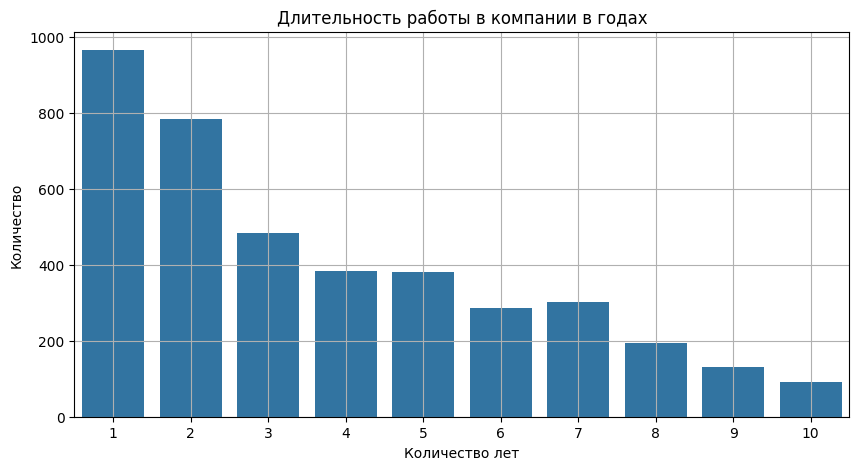

In [38]:
box_count_plot(job_X_train, 'employment_years', 'Длительность работы в компании в годах', 'Количество лет')

Вывод: по графику видно, что большая часть сотрудников работает в компании не более 3 лет.

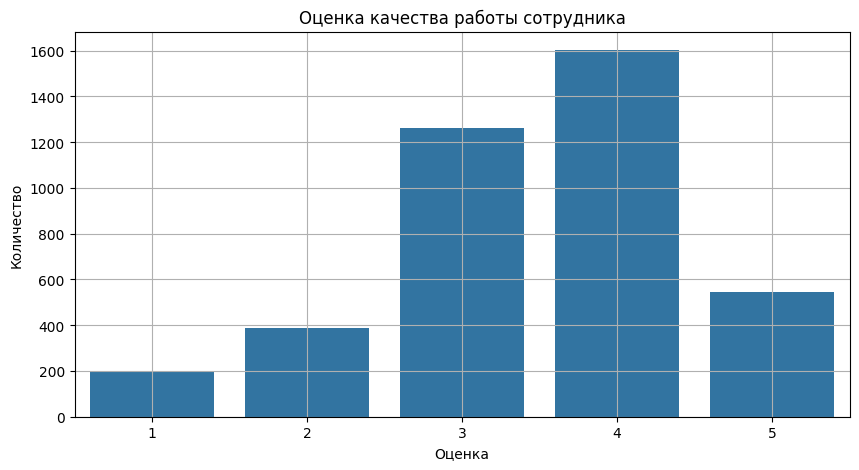

In [39]:
box_count_plot(job_X_train, 'supervisor_evaluation', 'Оценка качества работы сотрудника', 'Оценка')

Вывод: наибольшее количество сотрудников имеют удовлетворительные и хорошие оценки качества их работы.

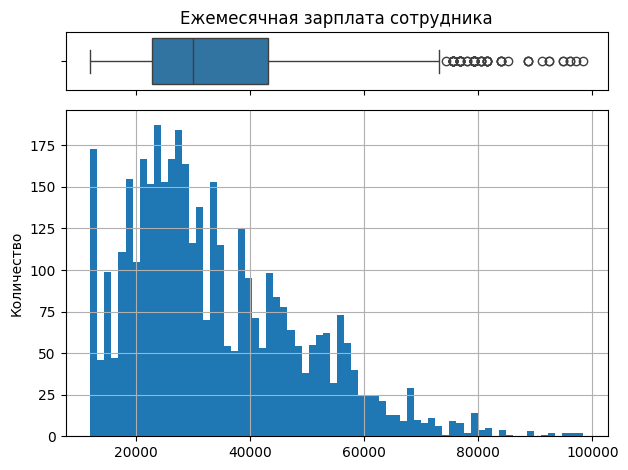

In [40]:
box_hist_plot(job_X_train, 'salary', 'Ежемесячная зарплата сотрудника', 70)

Вывод: нормальное распределение с положительной асимметрией. Имеются выбросы от которых не стоит избавляться, так как некоторые сотрудники могут получать зарплату больше, чем у остальных.

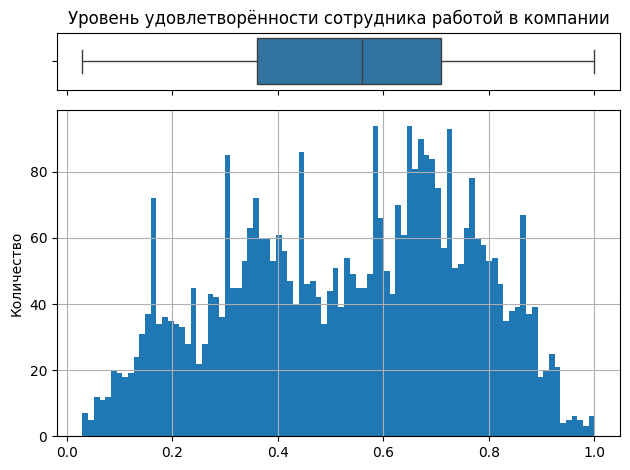

In [41]:
box_hist_plot(job_X_train, 'job_satisfaction_rate', 'Уровень удовлетворённости сотрудника работой в компании', 90)

Вывод: нормальное распределение с асимметрией, имеется несколько пиков.

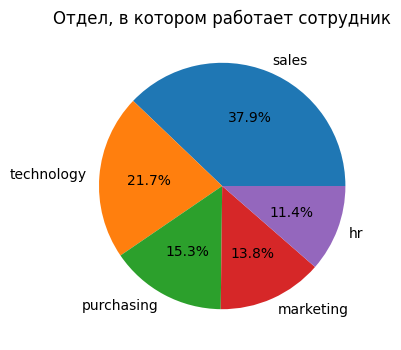

In [42]:
pie_plotter(job_X_train, 'dept', 'Отдел, в котором работает сотрудник')

Вывод: 38% сотрудников работают в продажах, 21,6% в сфере технологий.

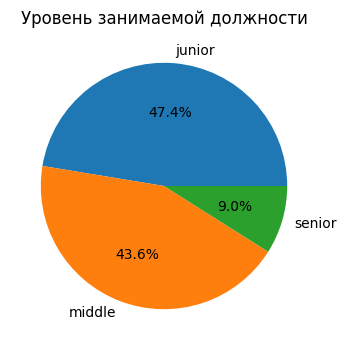

In [43]:
pie_plotter(job_X_train, 'level', 'Уровень занимаемой должности')

Вывод: Практически половина сотрудников имеют должности начинающих специалистов.

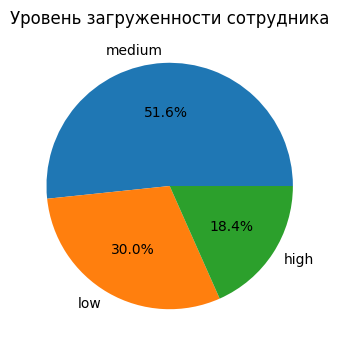

In [44]:
pie_plotter(job_X_train, 'workload', 'Уровень загруженности сотрудника')

Вывод: 51,6% имеют средний уровень загруженности.

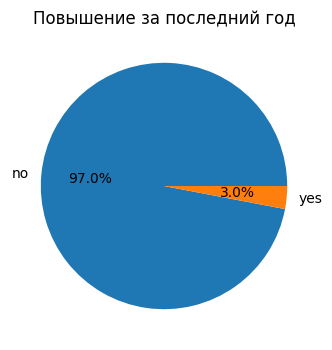

In [45]:
pie_plotter(job_X_train, 'last_year_promo', 'Повышение за последний год')

Вывод: Только 3% сотрудников повышали в течение последнего года.

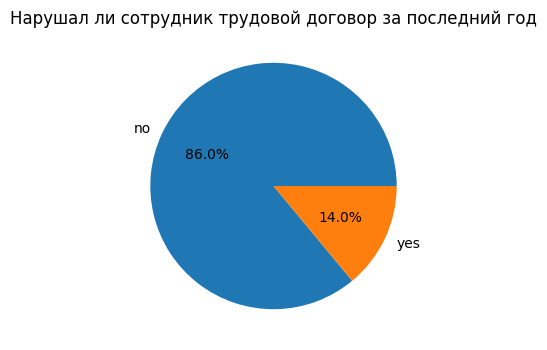

In [46]:
pie_plotter(job_X_train, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год')

Вывод: 86% не нарушали трудовой договор за последний год, 14% - нарушали.

In [47]:
interval_cols=['salary', 'job_satisfaction_rate']

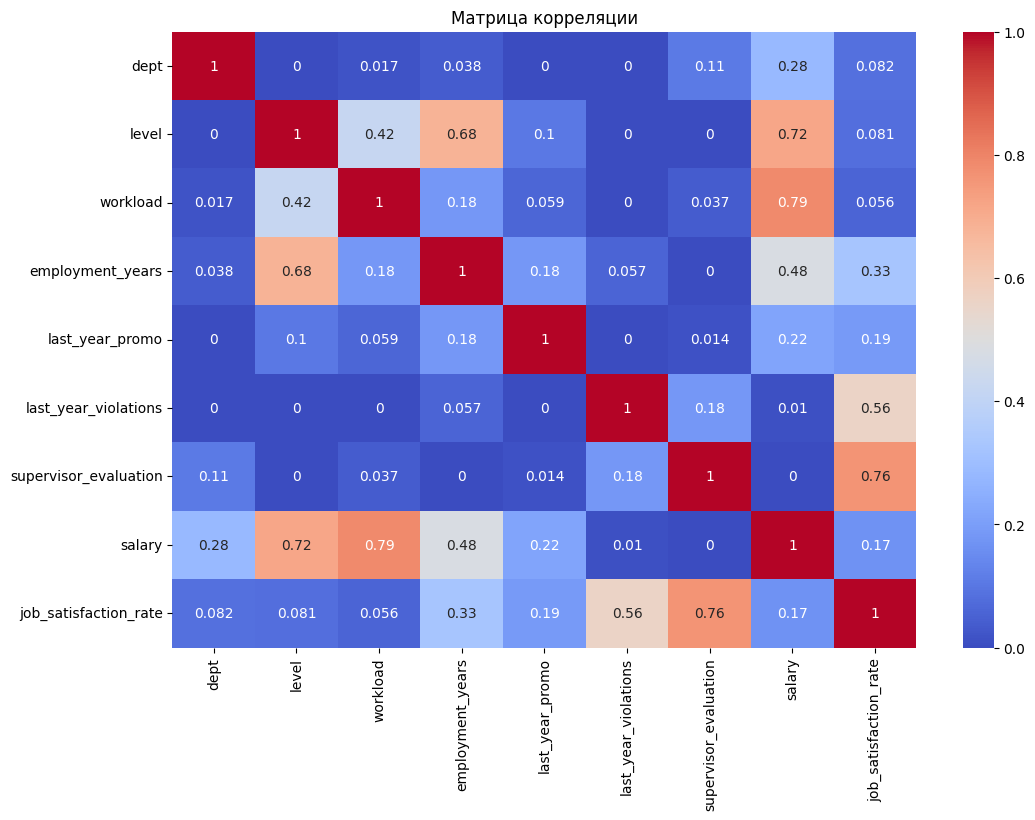

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(job_X_train.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

Вывод: мультиколлинеарность отсутствует. Целевой признак умерено коррелирует с признаками `last_year_violations` - 0.56, `supervisor_evaluation` - 0.76

#### job_X_test

In [49]:
job_X_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


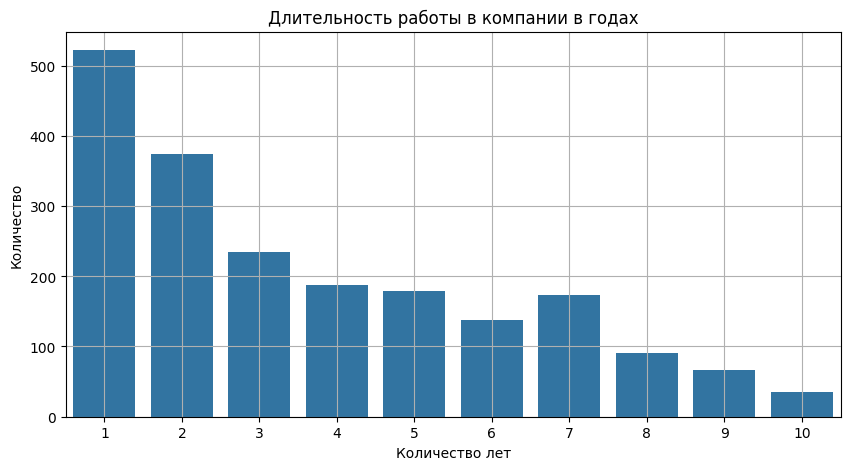

In [50]:
box_count_plot(job_X_test, 'employment_years', 'Длительность работы в компании в годах', 'Количество лет')

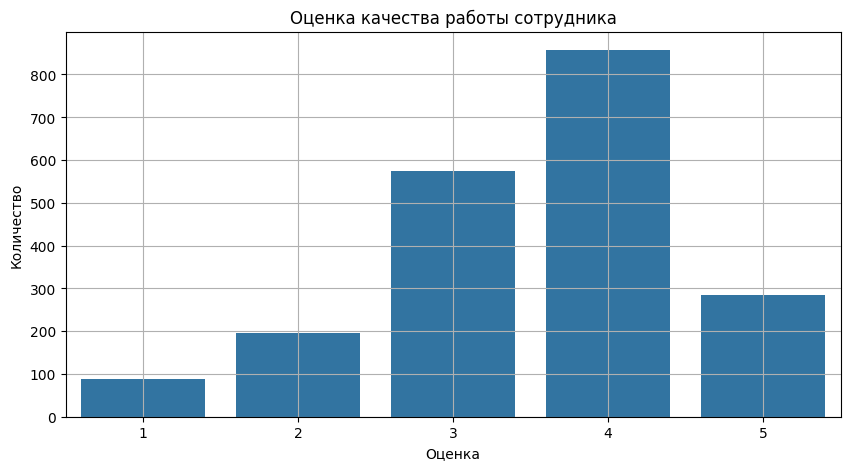

In [51]:
box_count_plot(job_X_test, 'supervisor_evaluation', 'Оценка качества работы сотрудника', 'Оценка')

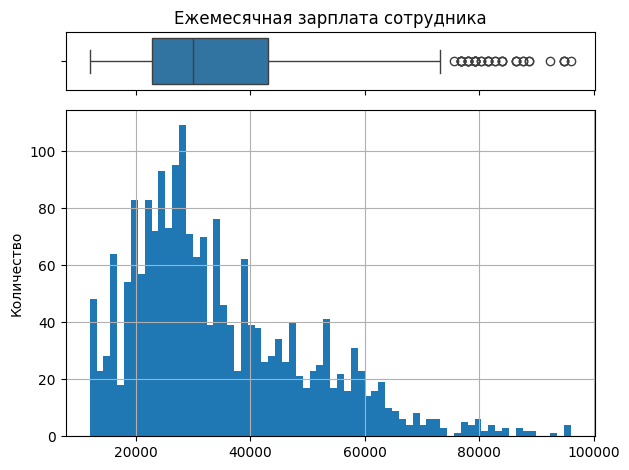

In [52]:
box_hist_plot(job_X_test, 'salary', 'Ежемесячная зарплата сотрудника', 70)

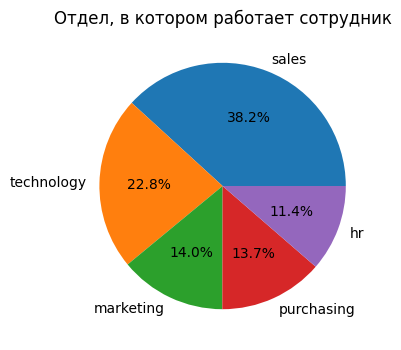

In [53]:
pie_plotter(job_X_test, 'dept', 'Отдел, в котором работает сотрудник')

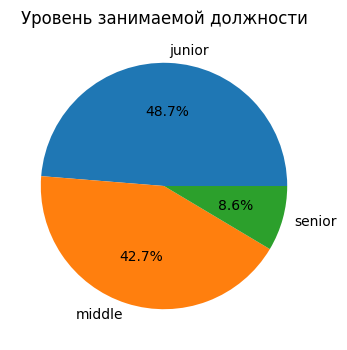

In [54]:
pie_plotter(job_X_test, 'level', 'Уровень занимаемой должности')

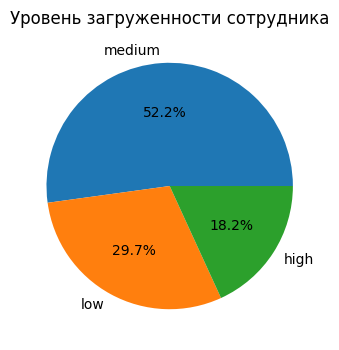

In [55]:
pie_plotter(job_X_test, 'workload', 'Уровень загруженности сотрудника')

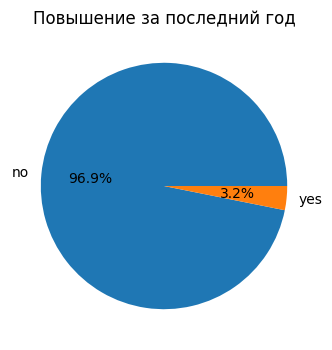

In [56]:
pie_plotter(job_X_test, 'last_year_promo', 'Повышение за последний год')

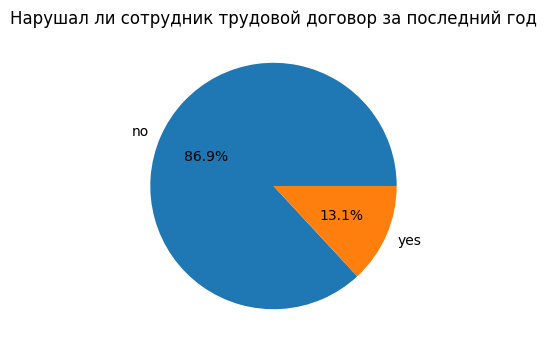

In [57]:
pie_plotter(job_X_test, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год')

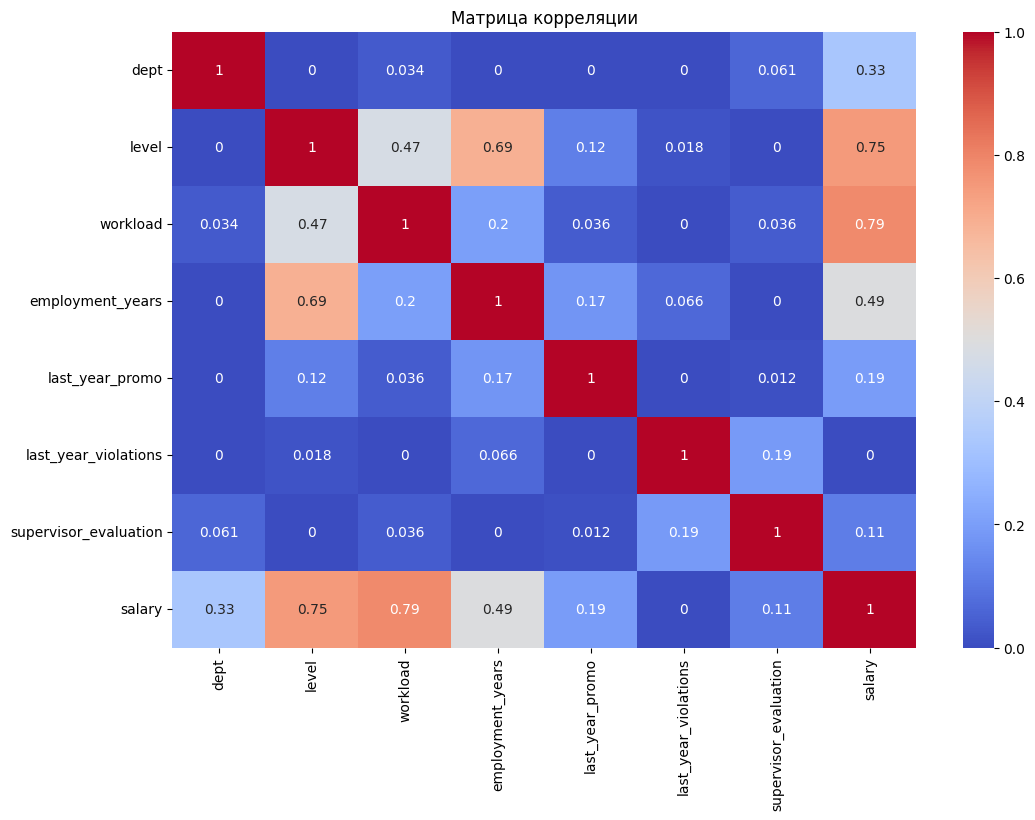

In [58]:
interval_cols=['employment_years',
               'supervisor_evaluation',
               'salary']

plt.figure(figsize=(12, 8))
sns.heatmap(job_X_test.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

Вывод: мультиколлинеарность отсутствует.

### Подготовка данных

In [59]:
job_X_train.set_index('id', inplace=True)
job_X_test.set_index('id', inplace=True)

In [60]:
# Количество дубликатов после сброса индекса
job_X_train.duplicated().sum()

245

In [61]:
# Удалим дубликаты
job_X_train.drop_duplicates(inplace=True, ignore_index=False)

job_X_train.duplicated().sum()

0

In [62]:
# разделим выборку на тренировочную и тестовую
X_train = job_X_train.drop('job_satisfaction_rate', axis=1)
y_train = job_X_train['job_satisfaction_rate']
X_test = job_X_test
y_test = job_y_test['job_satisfaction_rate']

print('Train:', X_train.shape, y_train.shape )
print('Test:', X_test.shape, y_test.shape)

Train: (3755, 8) (3755,)
Test: (2000, 8) (2000,)


In [63]:
# разбиваем данные на количественные и категориальные
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [64]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [65]:
# создаём пайплайн для подготовки признаков из списка ord_columns:
# SimpleImputer + Ordinal-кодирование
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
            ['junior', 'middle', 'senior'],
            ['medium', 'high', 'low']
        ],
             handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём пайплайн для подготовки признаков из списка num_columns:
num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler())
#    ('poly', PolynomialFeatures(2))
])

In [66]:
# создаем единый пайплайн
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [67]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [68]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(7, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    }
]

### Обучение моделей

In [69]:
#создаем метрику SMAPE
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

smape_score = make_scorer(smape, greater_is_better=False)

In [70]:
%%time
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring = smape_score,
    n_jobs = -1
)

# обучаем модель на тренировочной выборке
randomized_search.fit(X_train, y_train)

CPU times: total: 234 ms
Wall time: 566 ms


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__max_features': range(2, 20),
                                         'models__min_samples_split': range(7, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [71]:
print('Лучшая модель и её параметры:', randomized_search.best_estimator_)
print ('Метрика лучшей модели на корсс-валидации:', randomized_search.best_score_*-1)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                              

In [72]:
y_pred = randomized_search.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_pred)
print ("Метрика SMAPE на тестовой выборке равна:", smape_test)

Метрика SMAPE на тестовой выборке равна: 13.83598741331579


In [73]:
# Добавим предсказанные данные в таблицу
job_X_test['job_satisfaction_rate'] = y_pred
job_X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.834667
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.788462
100610,sales,middle,medium,5,no,no,4,43200,0.804000
100692,sales,middle,high,6,no,no,4,48000,0.702500


### Вывод по первой задаче:

**1. Загрузка и изучение данных.**
данные с характеристиками сотрудников компании:
- `job_X_train`: в данных имеется 4000 записей, в двух столбцах имеются пропуски;
- `job_X_test`: в данных имеется 2000 записей, в двух столбцах имеются пропуски;
- `job_y_test`: в данных имеется 2000 записей, пропуски отсутствуют;


**2. Анализ и подготовка данных.**

- Исправили опечатки в данных.
- Заполнили пропущенные значения.
- Отсортировали данные в порядке возрастания по столбцу `id`.
- После сброса индекса обнаружено 1500 дубликатов, которые были удалены.
- Проведен исследовательский анализ данных.
- Проведен корреляционный анализ, мультиколлинеарность признаков отсутствует.
- Подготовили пайплайны для отбора лучшей модели.


**3. Лучшая модель.**


- Создали функцию новой метрики `SMAPE` (симметричное среднее абсолютное процентное отклонение)
- Лучшей моделью является `DecisionTreeRegressor(max_depth=15, max_features=13, min_samples_split=13, random_state=42)`
- Значение метрики на кросс-валидации: 15.590197395127039
- Значение метрики на тестовой выборке: 13.83598741331579


## Предсказание увольнения сотрудника из компании

### Изучение данных

In [74]:
# Выводим первые пять строк
quit_X_train.head() 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [75]:
# Выведем информацию о датасете
quit_X_train.info()
# Посмотрим пропуски в данных
quit_X_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [76]:
job_X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.834667
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.788462
100610,sales,middle,medium,5,no,no,4,43200,0.804000
100692,sales,middle,high,6,no,no,4,48000,0.702500


In [77]:
# Выводим первые пять строк
quit_y_test.head() 

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [78]:
# Выведем информацию о датасете
quit_y_test.info()
# Посмотрим пропуски в данных
quit_y_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


id      0
quit    0
dtype: int64

**Вывод:**
- `quit_X_train`: в данных имеется 4000 записей, пропуски отсутствуют;
- `quit_y_test`: в данных имеется 2000 записей, пропуски отсутствуют.

### Предобработка данных

In [79]:
quit_X_train['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [80]:
quit_X_train['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [81]:
# Заменим опечатку
quit_X_train['level'].replace({'sinior': 'senior'}, inplace=True)
quit_X_train['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [82]:
quit_X_train['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [83]:
quit_X_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [84]:
quit_X_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [85]:
quit_X_train['quit'].unique()

array(['no', 'yes'], dtype=object)

In [86]:
quit_X_train = quit_X_train.set_index('id').sort_values(by='id')
quit_X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100469,marketing,junior,medium,1,no,no,4,28800,no
100601,technology,middle,high,4,no,no,4,68400,no
100858,sales,junior,medium,2,no,no,4,25200,yes


In [87]:
job_X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.834667
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.788462
100610,sales,middle,medium,5,no,no,4,43200,0.804000
100692,sales,middle,high,6,no,no,4,48000,0.702500


In [88]:
quit_y_test = quit_y_test.set_index('id')
quit_test = job_X_test.merge(quit_y_test, right_index=True, left_index=True)
quit_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.834667,no
100480,marketing,junior,low,4,no,no,4,16800,0.841667,no
100503,purchasing,middle,high,5,no,no,4,55200,0.788462,no
100610,sales,middle,medium,5,no,no,4,43200,0.804000,no
100692,sales,middle,high,6,no,no,4,48000,0.702500,no


**Вывод:**
- Исправили опечатки в данных.
- Отсортировали данные в порядке возрастания по столбцу `id`.
- Соеденили таблицы с тестовыми данными в одну по индексу.

### Исследовательский анализ

#### Общий исследовательский анализ

In [89]:
quit_X_train.describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


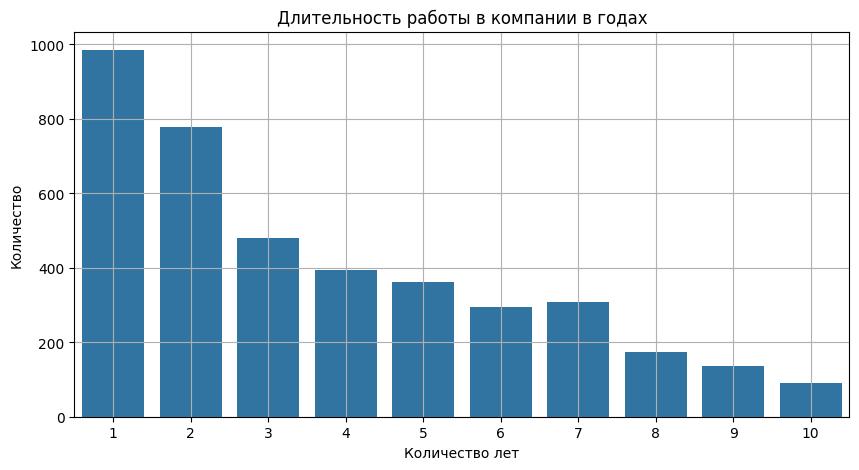

In [90]:
box_count_plot(quit_X_train, 'employment_years', 'Длительность работы в компании в годах', 'Количество лет')

Вывод: по графику видно, что большая часть сотрудников работает в компании не более 5 лет.

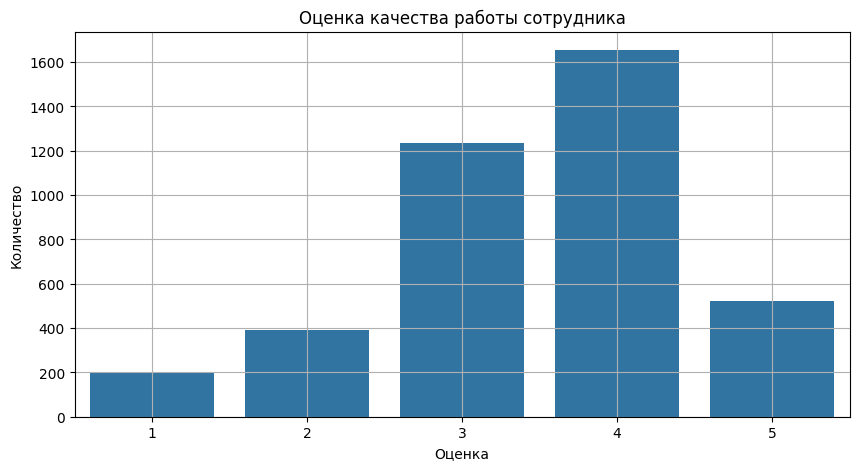

In [91]:
box_count_plot(quit_X_train, 'supervisor_evaluation', 'Оценка качества работы сотрудника', 'Оценка')

Вывод: наибольшее количество сотрудников имеют удовлетворительные и хорошие оценки качества их работы.

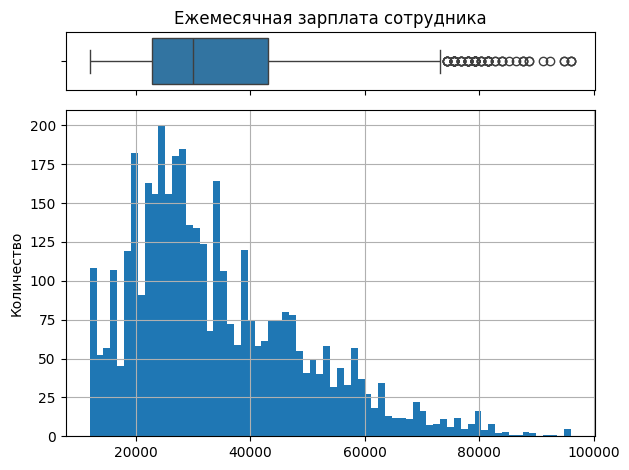

In [92]:
box_hist_plot(quit_X_train, 'salary', 'Ежемесячная зарплата сотрудника', 70)

In [93]:
quit_X_train.groupby('quit')['salary'].median()

quit
no     34800
yes    22800
Name: salary, dtype: int64

Вывод: нормальное распределение с положительной асимметрией. Имеются выбросы от которых не стоит избавляться, так как некоторые сотрудники могут получать зарплату больше, чем у остальных.

Уволенные сотрудники в среднем получали 22 800, работающие - 34 800.

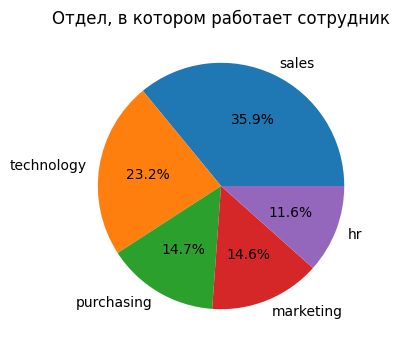

In [94]:
pie_plotter(quit_X_train, 'dept', 'Отдел, в котором работает сотрудник')

Вывод: 35.9% сотрудников работают в продажах, 23.2% в сфере технологий.

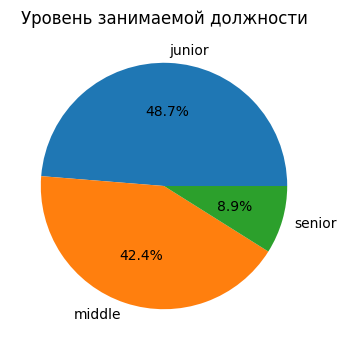

In [95]:
pie_plotter(quit_X_train, 'level', 'Уровень занимаемой должности')

Вывод: Практически половина сотрудников имеют должности начинающих специалистов.

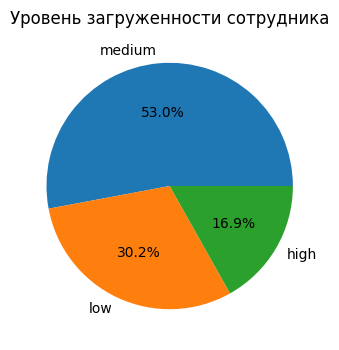

In [96]:
pie_plotter(quit_X_train, 'workload', 'Уровень загруженности сотрудника')

Вывод: 53.0% имеют средний уровень загруженности

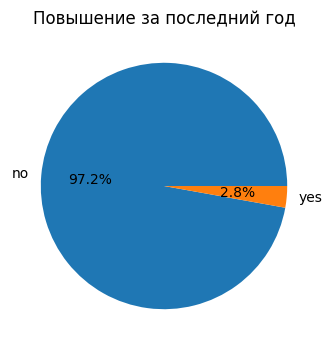

In [97]:
pie_plotter(quit_X_train, 'last_year_promo', 'Повышение за последний год')

Вывод: Только 2.8% сотрудников повышали в течение последнего года.

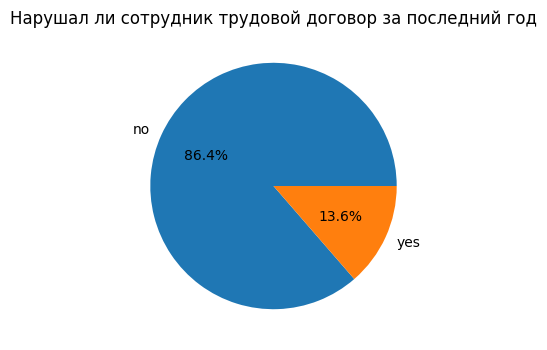

In [98]:
pie_plotter(quit_X_train, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор за последний год')

Вывод: 86.4% не нарушали трудовой договор за последний год, 13.6% - нарушали.

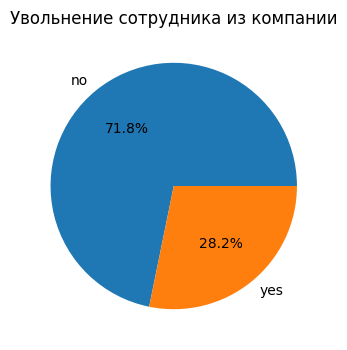

In [99]:
pie_plotter(quit_X_train, 'quit', 'Увольнение сотрудника из компании')

Вывод: 28,2% сотрудников было уволено.

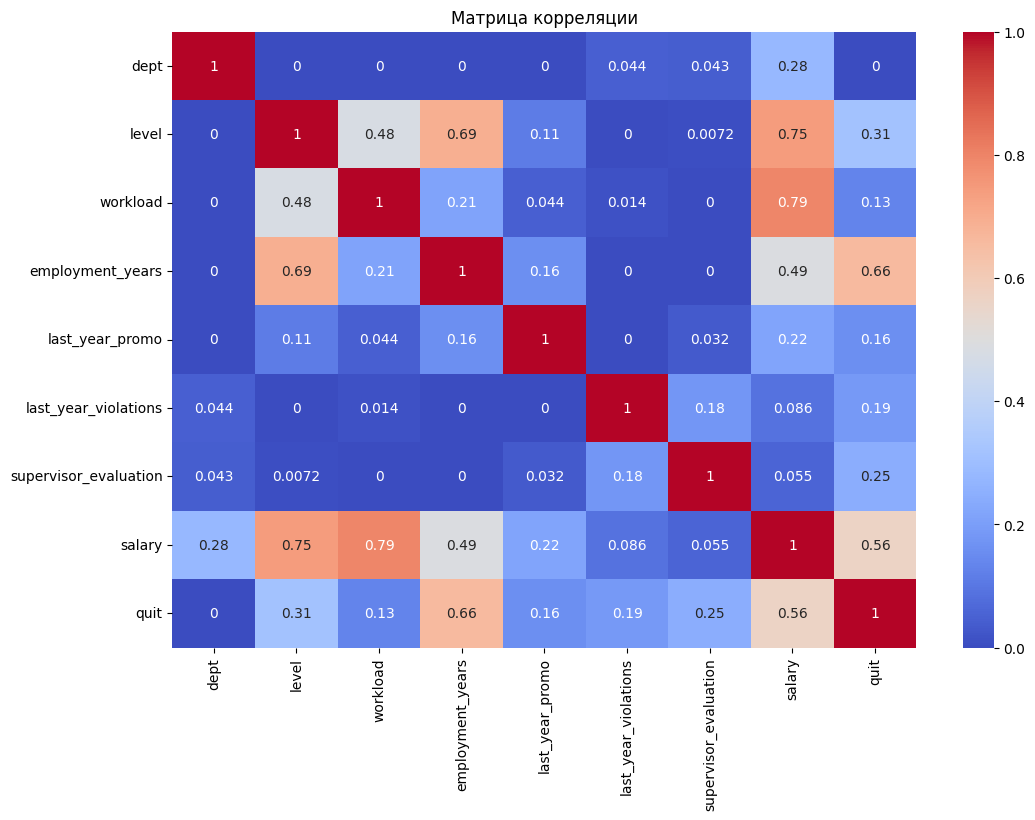

In [100]:
interval_cols=['salary']

plt.figure(figsize=(12, 8))
sns.heatmap(quit_X_train.phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

Вывод: мультиколлинеарность отсутствует. Целевой признак умеренно коррелирует с признаками `employment_years` - 0.66,  `salary` - 0.56

#### Портрет "уволившегося сотрудника"

In [101]:
quit = quit_X_train.loc[quit_X_train['quit'] == 'yes']
not_quit = quit_X_train.loc[quit_X_train['quit'] == 'no']
quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes
100969,marketing,junior,medium,2,no,no,3,26400,yes
102630,technology,junior,medium,2,no,no,2,30000,yes


In [102]:
quit['dept'].value_counts(normalize=True)

sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64

In [103]:
quit['level'].value_counts(normalize=True)

junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64

In [104]:
quit['workload'].value_counts(normalize=True)

low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64

In [105]:
quit['employment_years'].value_counts(normalize=True)

1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64

In [106]:
quit['last_year_promo'].value_counts(normalize=True)

no     0.999113
yes    0.000887
Name: last_year_promo, dtype: float64

In [107]:
quit['last_year_violations'].value_counts(normalize=True)

no     0.797872
yes    0.202128
Name: last_year_violations, dtype: float64

In [108]:
quit['supervisor_evaluation'].value_counts(normalize=True)

3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: supervisor_evaluation, dtype: float64

In [109]:
print('Средняя зарплата уволившегося сотрудника:', quit['salary'].mean().round(2))
print('Средняя зарплата работающего сотрудника:', not_quit['salary'].mean().round(2))
print('Средняя разница в зарплатах:', (not_quit['salary'].mean() - quit['salary'].mean()).round(2))

Средняя зарплата уволившегося сотрудника: 23885.11
Средняя зарплата работающего сотрудника: 37702.23
Средняя разница в зарплатах: 13817.12


**Портрет "уволившегося сотрудника":**
- Вероятнее работает в отделе продаж.
- Имеет должность начинающего специалиста.
- Имеет низкий или средний уровень загруженности.
- В среднем работал 1-2 года в компании.
- Не имел повышения в последний год.
- Не имел нарушений по трудовому договору.
- Имеет оценку "3" качества работы.
- В среднем зарабатывает 22 800.

#### Уровень удовлетворенности сотрудника работой

In [110]:
data = job_y_test.merge(quit_y_test, on='id', how='left')
data = data.set_index('id')
data.head()

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


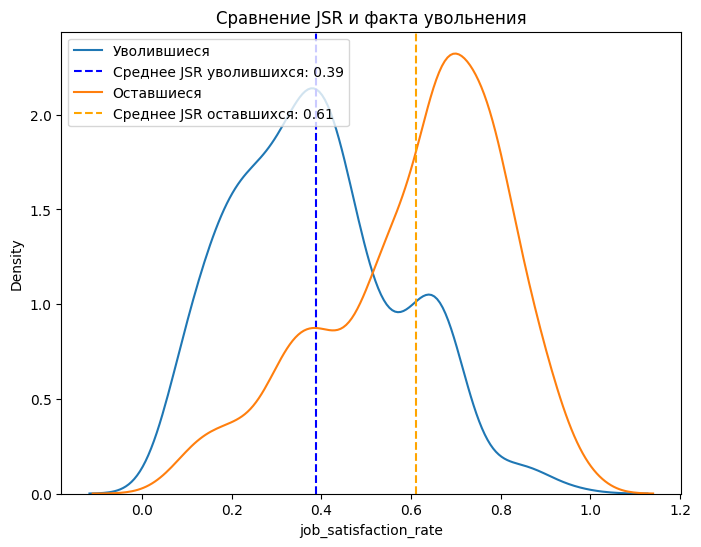

In [111]:
data_quit = data.loc[data['quit'] == 'yes']
data_not_quit = data.loc[data['quit'] == 'no']

fig, axes = plt.subplots(figsize=(8, 6))

# График №1
sns.kdeplot(
    data = data_quit['job_satisfaction_rate'],
    label = 'Уволившиеся',
    ax = axes
)

# Медиана для графика №1
mean_quit = data_quit['job_satisfaction_rate'].mean()
axes.axvline(
    mean_quit,
    color = 'blue',
    linestyle = '--',
    label = f'Среднее JSR уволившихся: {mean_quit:.2f}'
)

# График №2
sns.kdeplot(
    data = data_not_quit['job_satisfaction_rate'],
    label = 'Оставшиеся',
    ax = axes
)

# Медиана для графика №2
mean_not_quit = data_not_quit['job_satisfaction_rate'].mean()
axes.axvline(
    mean_not_quit,
    color = 'orange',
    linestyle = '--',
    label = f'Среднее JSR оставшихся: {mean_not_quit:.2f}'
)

axes.set_title('Сравнение JSR и факта увольнения')
plt.legend(loc='upper left')
plt.show()

**Вывод:**
В среднем уровень удовлетворённости сотрудника работой в компании влияет на увольнение сотрудника. У работающих уровень в 1.5 раза больше, чем у уволенных сотрудников.

### Добавление нового входного признака

In [112]:
# Создаем копию исходного датасета
quit_train = quit_X_train.copy(deep=True)
# добавляем новый признак
quit_train['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(quit_train)
quit_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.345714
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.333333
100469,marketing,junior,medium,1,no,no,4,28800,no,0.658462
100601,technology,middle,high,4,no,no,4,68400,no,0.678000
100858,sales,junior,medium,2,no,no,4,25200,yes,0.837273


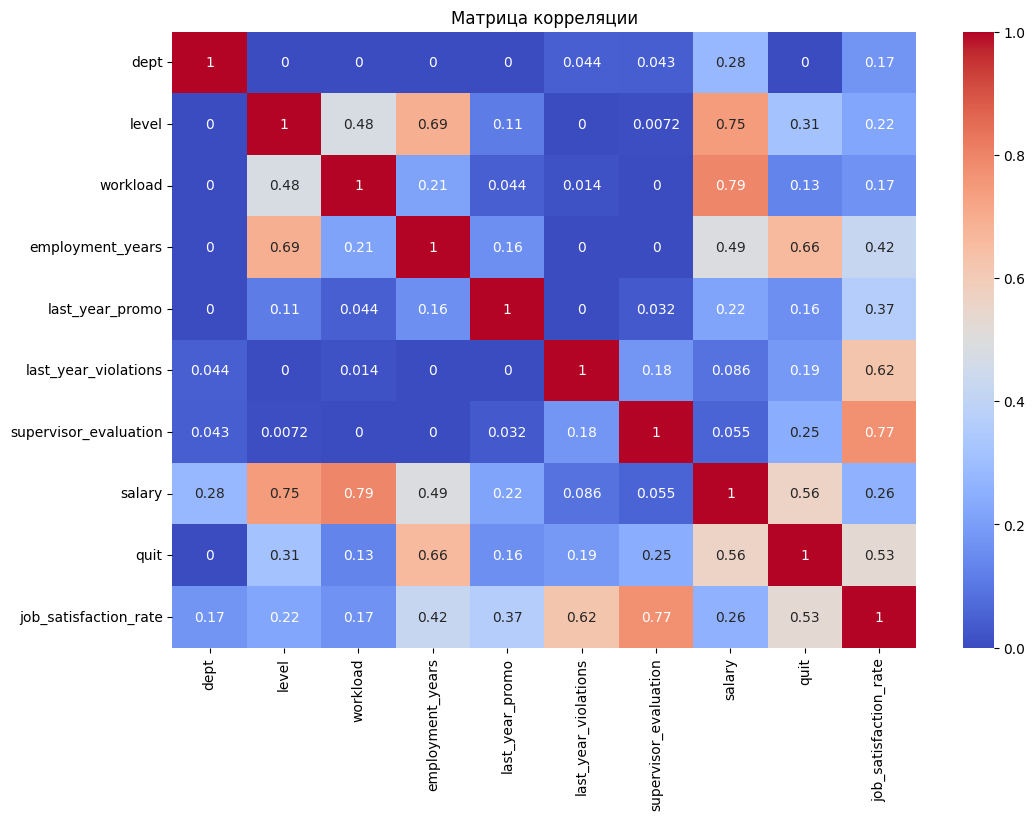

In [113]:
# Корреляционный анализ
interval_cols=['salary', 'job_satisfaction_rate']

plt.figure(figsize=(12, 8))
sns.heatmap(quit_train.phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

Вывод: мультиколлинеарность отсутствует. Целевой признак умеренно коррелирует с признаками `employment_years` - 0.66,  `salary` - 0.56

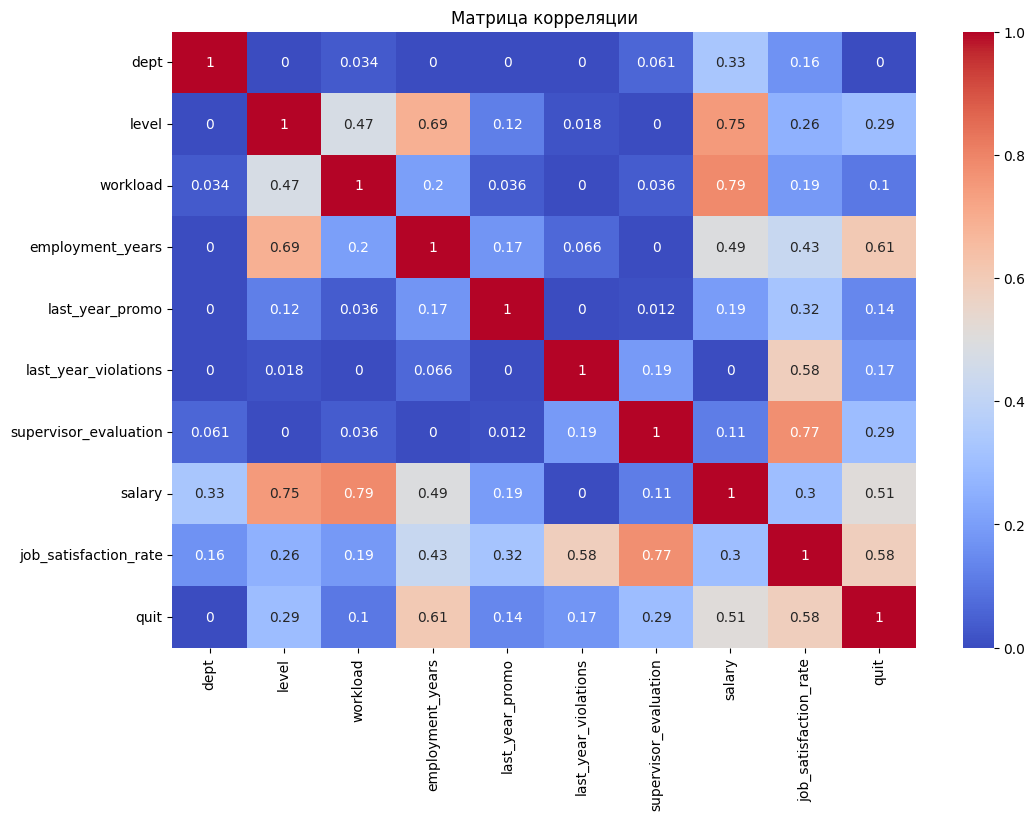

In [114]:
# Корреляционный анализ
interval_cols=['salary', 'job_satisfaction_rate']

plt.figure(figsize=(12, 8))
sns.heatmap(quit_test.phik_matrix(interval_cols=interval_cols), annot=True, cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

Вывод: мультиколлинеарность отсутствует. Целевой признак умеренно коррелирует с признаками `employment_years` и `job_satisfaction_rate` - 0.61,  `salary` - 0.51

### Подготовка данных

In [115]:
# Количество дубликатов после сброса индекса
quit_train.duplicated().sum()

1413

In [116]:
# Удалим дубликаты
quit_train.drop_duplicates(inplace=True, ignore_index=False)

quit_train.duplicated().sum()

0

In [117]:
# разделим выборку на тренировочную и тестовую
X_train_2 = quit_train.drop('quit', axis=1)
y_train_2 = quit_train['quit']
X_test_2 = quit_test.drop('quit', axis=1)
y_test_2 = quit_test['quit']

print('Train:', X_train_2.shape, y_train_2.shape )
print('Test:', X_test_2.shape, y_test_2.shape)

le = LabelEncoder()
le.fit_transform(y_train_2)
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
y_train = le.transform(y_train_2)
y_test = le.transform(y_test_2)

Train: (2587, 9) (2587,)
Test: (2000, 9) (2000,)
Значениям ['no' 'yes'] назначено соответственно [0 1]


In [118]:
# разбиваем данные на количественные и категориальные
ohe_columns_2 = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [119]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier())
    ]
)

### Обучение моделей

In [120]:
param_grid_2 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    }
]

In [121]:
%%time
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

# обучаем модель на тренировочной выборке
randomized_search_2.fit(X_train_2, y_train_2)

CPU times: total: 641 ms
Wall time: 1.22 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__penalty': ['l1', 'l2'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 15),
                                         'models__kernel': ['poly', 'rbf',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [ ]:
print('Лучшая модель и её параметры:', randomized_search_2.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [123]:
print('Площадь ROC-кривой на кросс-валидации:', randomized_search_2.best_score_)
roc_auc_test = roc_auc_score(y_test_2, randomized_search_2.predict_proba(X_test_2)[:, 1])
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_test)
roc_auc_km = (roc_auc_test - randomized_search_2.best_score_) / randomized_search_2.best_score_*100
print(f'Потеря качества на тестовой выборке  = {roc_auc_km:.2f} %')

Площадь ROC-кривой на кросс-валидации: 0.900351519507189
Площадь ROC-кривой на тестовой выборке: 0.9215518135482723
Потеря качества на тестовой выборке  = 2.35 %


### Вывод по второй задаче


**1. Загрузка и изучение данных.**
данные с характеристиками сотрудников компании:
- `quit_X_train`: в данных имеется 4000 записей, пропуски отсутствуют;
- `quit_y_test`: в данных имеется 2000 записей, пропуски отсутствуют.


**2. Анализ и подготовка данных.**

- Исправили опечатки в данных.
- Отсортировали данные в порядке возрастания по столбцу `id`.
- После сброса индекса обнаружено 1545 дубликатов, которые были удалены.
- Проведен исследовательский анализ данных.
- Проведен корреляционный анализ, мультиколлинеарность признаков отсутствует.
- Подготовили пайплайны для отбора лучшей модели.


**3. Лучшая модель.**


- Лучшей моделью является `SVC(degree=12, probability=True, random_state=42)`

Площадь ROC-кривой на кросс-валидации: 0.900351519507189

Площадь ROC-кривой на тестовой выборке: 0.9208554347181888

Увеличение качества модели на тестовой выборке  = 2.35 %

## Общий вывод

**1. Загрузка и изучение данных.**
данные с характеристиками сотрудников компании:
- `job_X_train`:
    - в данных имеется 4000 записей, в двух столбцах имеются пропуски;
- `job_X_test`:
    - в данных имеется 2000 записей, в двух столбцах имеются пропуски;
- `job_y_test`: 
    - в данных имеется 2000 записей, пропуски отсутствуют;
- `quit_X_train`:
    - в данных имеется 4000 записей, пропуски отсутствуют;
- `quit_y_test`:
    - в данных имеется 2000 записей, пропуски отсутствуют.


**2. Анализ данных.**

- Исправили опечатки в данных.
- Отсортировали данные в порядке возрастания по столбцу `id`.
- Проведен исследовательский анализ данных:
    - Большая часть сотрудников работает в компании не более 5 лет.
    - Наибольшее количество сотрудников имеют удовлетворительные и хорошие оценки качества их работы.
    - Медианная зарплата в компании - 30 000.
    - Больше всего сотрудников работает в продажаз - 38%.
    - 47.5% сотрудников занимают должность junior, примерно столько же в компании и специалистов middle (43.6%). Более всего удовлетворены рабочим местом сотрудники middle
    - Большая часть сотрудников (51,6%) имеют среднюю загруженность.
- Проведен корреляционный анализ, мультиколлинеарность признаков отсутствует:
    - Целевой признак `job_satisfaction_rate` умерено коррелирует с признаками `last_year_violations` - 0.56, `supervisor_evaluation` - 0.76
    - Целевой признак `quit` умеренно коррелирует с признаками `employment_years` - 0.66,  `salary` - 0.56
- Подготовили пайплайны для для отбора лучшей модели. Применили кодирование и масштабирование данных с помощью:
    - `OneHotEncoder`
    - `OrdinalEncoder`
    - `StandardScaler`
    - `PolynomialFeatures`
- **Портрет "уволившегося сотрудника":**
    - Вероятнее работает в отделе продаж.
    - Имеет должность начинающего специалиста.
    - Имеет низкий или средний уровень загруженностию
    - В среднем работал 1-2 года в компаниию
    - Не имел повышения в последний год.
    - Имеет оценку "3" качества работы.
    - В среднем зарабатывает 22 800.

**3. Лучшая модель.**

1. Задача регресии:
    - Создали функцию новой метрики `SMAPE` (симметричное среднее абсолютное процентное отклонение)
    - Лучшей моделью является `DecisionTreeRegressor(max_depth=15, max_features=13, min_samples_split=13, random_state=42)`
    - Значение метрики на кросс-валидации: 15.590197395127039
    - Значение метрики на тестовой выборке: 13.83598741331579
    
2. Задача классификации:
    - - Лучшей моделью является `SVC(degree=12, probability=True, random_state=42)`
    - Площадь ROC-кривой на кросс-валидации: 0.900351519507189
    - Площадь ROC-кривой на тестовой выборке: 0.9215518135482723
    - качество модели на тестовой выборке увеличилось на 2.35 %
    
    
**4. Предложения для бизнеса.**

- Проведение курсов, семинаров для сотрудников для повышения квалификации.
- Внедрение бонусов и премий за достижения сотрудников.
- Формирование корпаративной культуры, сплочение коллектива.